# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [114]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). **Make sure you explain your decisions whenever necessary.** 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

In [115]:
df = pd.read_csv("train__dataset.csv")
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


The target column here is booking_status. 
The data set provides a lot of information but some of it doesn't apply to the study. This included, Booking_ID, arrival_year and possibly typeofmeal_plan. 
Majority of the data is numerical while the rest is ordinal and binary data.

Just looking at the data displayed when the dataframe is printed, there might be a class imbalance in the ordinal data


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [116]:
train_df, test_df = train_test_split(df, test_size = 0.4)


train_df_X = train_df.drop(["booking_status"], axis = 1)
train_df_y = train_df["booking_status"]
test_df_X = train_df.drop(["booking_status"], axis = 1)
test_df_y = train_df["booking_status"]




<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [117]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10882 entries, 12274 to 10256
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          10882 non-null  int64  
 1   no_of_children                        10882 non-null  int64  
 2   no_of_weekend_nights                  10882 non-null  int64  
 3   no_of_week_nights                     10882 non-null  int64  
 4   type_of_meal_plan                     10882 non-null  int64  
 5   required_car_parking_space            10882 non-null  int64  
 6   room_type_reserved                    10882 non-null  int64  
 7   lead_time                             10882 non-null  int64  
 8   arrival_year                          10882 non-null  int64  
 9   arrival_month                         10882 non-null  int64  
 10  arrival_date                          10882 non-null  int64  
 11  market_segm

In [118]:
train_df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000,10882.000000
mean,1.843871,0.108987,0.809686,2.212369,0.315567,0.031244,0.337806,84.953777,2017.821816,7.443485,15.606322,0.814832,0.026650,0.022422,0.173406,103.251674,0.611101,0.327881
std,0.515163,0.408838,0.875320,1.433968,0.626172,0.173985,0.776234,86.124466,0.382685,3.077376,8.734330,0.660565,0.161064,0.356195,1.973303,35.527281,0.789613,0.469463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,16.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.502500,1.000000,1.000000
max,4.000000,9.000000,6.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,11.000000,58.000000,300.000000,5.000000,1.000000


In [119]:
columns = train_df.columns.values.tolist()
nan_values = []
for i in columns:
    nan_values.append(train_df[i].isnull().sum())
nanValues = pd.DataFrame(columns, nan_values)
nanValues
##no null vaues in any of the columns 

,0
0,no_of_adults
0,no_of_children
0,no_of_weekend_nights
0,no_of_week_nights
0,type_of_meal_plan
0,required_car_parking_space
0,room_type_reserved
0,lead_time
0,arrival_year
0,arrival_month


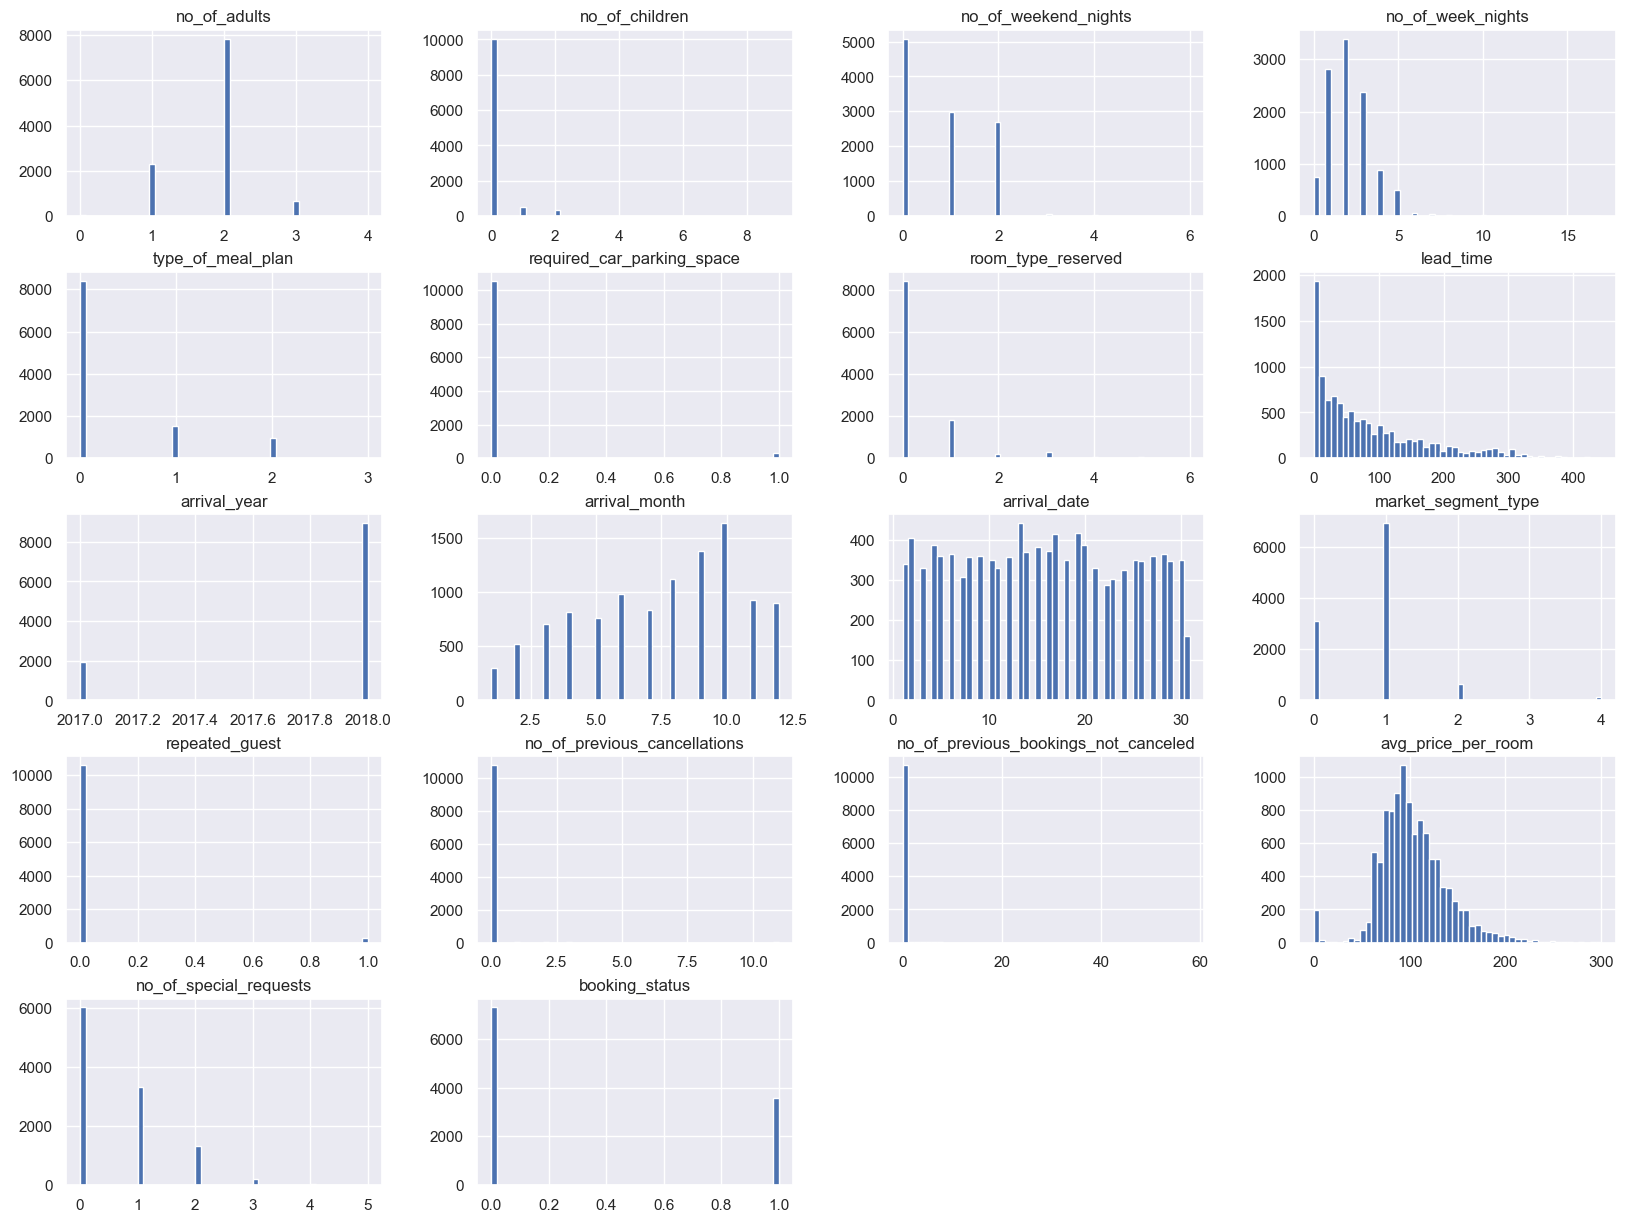

In [120]:
train_df.hist(bins=50, figsize=(20, 15));

- required car parking space, repeated guest, no of previous cancellation, no of children all have a very clear imbalance with majority of the examples having 1 certain value for each of the features
    - need to implement weightage for these features → required parking space and no of children should be ordinal?
- no of previous bookings not canceled; all the examples have the same value ← useless for training
- arrival year is either 2017 or 2018, the problem requires use to predict whether future bookings will be canceled therefore i feel that the arrival year wouldn’t be too helpful in this
- all of the values are numbers, the features are either numeric, ordinal or binary
    - the numeric features need to be scaled

Precision is the appropriate metric for this because, in this case, a false Positive harmful to the hotel as it would be very detremental to the hotel. If it acts upon a false postive, the hotel a very a customer or in the worse case scenrio customers. This would smear the hotel's reputation which in turn would lead to heavy losses.

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [121]:
train_df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10882 entries, 12274 to 10256
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          10882 non-null  int64  
 1   no_of_children                        10882 non-null  int64  
 2   no_of_weekend_nights                  10882 non-null  int64  
 3   no_of_week_nights                     10882 non-null  int64  
 4   type_of_meal_plan                     10882 non-null  int64  
 5   required_car_parking_space            10882 non-null  int64  
 6   room_type_reserved                    10882 non-null  int64  
 7   lead_time                             10882 non-null  int64  
 8   arrival_year                          10882 non-null  int64  
 9   arrival_month                         10882 non-null  int64  
 10  arrival_date                          10882 non-null  int64  
 11  market_segm

In [122]:
numeric = ["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", "arrival_year", "arrival_month", "arrival_date", "market_segment_type", 
           "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled", "avg_price_per_room", "no_of_special_requests", "lead_time"] #there is a large amount of variation for 
ordinal = ["type_of_meal_plan", "room_type_reserved"] #normally we would apply the ordinal encoder but in this case they are already in a numeric form
binary = ["required_car_parking_space", "repeated_guest"] #no transformation is needed for binary data

columnTransformer = make_column_transformer (
    (StandardScaler(),numeric),
    ("passthrough", (binary + ordinal))
)

transformed_x = columnTransformer.fit_transform(train_df_X)
transformed_x_test = columnTransformer.transform(test_df_X)
transformed_x = pd.DataFrame(transformed_x, columns = list(train_df_X.columns.values))
transformed_x_test = pd.DataFrame(transformed_x_test, columns = list(test_df_X.columns.values))

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [123]:
model = DummyClassifier(strategy="stratified")
model.fit(transformed_x, train_df_y)
model.score(transformed_x_test, test_df_y)

0.5657048336702812

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [124]:
lr = LogisticRegression()
lr.fit(transformed_x, train_df_y)
s = lr.score(transformed_x_test, test_df_y)
print(s)


param_grid = {"C":[0.001, 0.01, 0.1, 1, 10, 100]}
results = []
best_score = 0
best_C = 0

grid = GridSearchCV(lr, param_grid, cv = 5, scoring = "precision")
grid.fit(transformed_x, train_df_y)

meanScores = grid.cv_results_["mean_test_score"]
standardDeviation = grid.cv_results_["std_test_score"]
p = pd.DataFrame(param_grid)
p['meanScores'] = meanScores
p["standardDeviation"] = standardDeviation
p




0.7908472707222937


,C,meanScores,standardDeviation
0,0.001,0.813565,0.015280
1,0.010,0.739648,0.016187
2,0.100,0.727070,0.016171
3,1.000,0.724191,0.016173
4,10.000,0.723828,0.017374
5,100.000,0.723828,0.017374


C = 0.001 has the best mean score but also the highest Standard Deviation and therefore had the highest variation in the scores. As the value of C increases, the standard deviation decreases but the mean score alos siginificantly decreases after c = 0.001. 

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "forest_model":0,
    "decisionTreeClassifier": 0,
    "kNeighborsClassifier": 0
}


forest_model = RandomForestClassifier(random_state=123, n_estimators=5)
scores = cross_val_score(forest_model, transformed_x, train_df_y, scoring="precision")
models["forest_model"] = np.mean(scores)

decisionTreeClassifier = DecisionTreeClassifier()
scores = cross_val_score(decisionTreeClassifier, transformed_x, train_df_y, scoring="precision")
models["decisionTreeClassifier"] = np.mean(scores)

kNeighborsClassifier = KNeighborsClassifier(n_neighbors = 3)
scores = cross_val_score(kNeighborsClassifier, transformed_x, train_df_y, scoring="precision")
models["kNeighborsClassifier"] = np.mean(scores)

models



{'forest_model': 0.8074174686594123,
 'decisionTreeClassifier': 0.7492498837637985,
 'kNeighborsClassifier': 0.7285704862788416}

Random Forest Classifier has the best mean score out of the three in Q8 as well as beats logistic regression. Decision Tree Classifier and K Neighbor Classifier both had similar scores while forest model and logistic regressor had similar but much better scores that the other two. 

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [126]:
param_grid = {
    "n_estimators" : [1, 5, 10, 25, 50],
    "max_depth" : [None, 10, 15, 20],
    "max_features" : ["sqrt", "log2"]
}

##r = RandomForestClassifier()
grid = GridSearchCV(r, param_grid, cv = 5)

grid.fit(transformed_x, train_df_y)




GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, max_features='log2',
                                              n_estimators=50),
             param_grid={'max_depth': [None, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 5, 10, 25, 50]})

In [127]:
meanScore = grid.cv_results_["mean_test_score"]
bestPams = grid.best_params_
bestScore = grid.best_score_
bestPams
results = pd.DataFrame(grid.cv_results_)

forest_model = RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=50, random_state=123)
scores = cross_val_score(forest_model, transformed_x, train_df_y, scoring="precision")
np.mean(scores)


0.8554880174492684

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

,Importance
repeated_guest,0.326625
arrival_date,0.154969
market_segment_type,0.113677
required_car_parking_space,0.075020
room_type_reserved,0.066346
lead_time,0.063462
no_of_week_nights,0.045182
no_of_weekend_nights,0.035398
type_of_meal_plan,0.033079
no_of_adults,0.026564


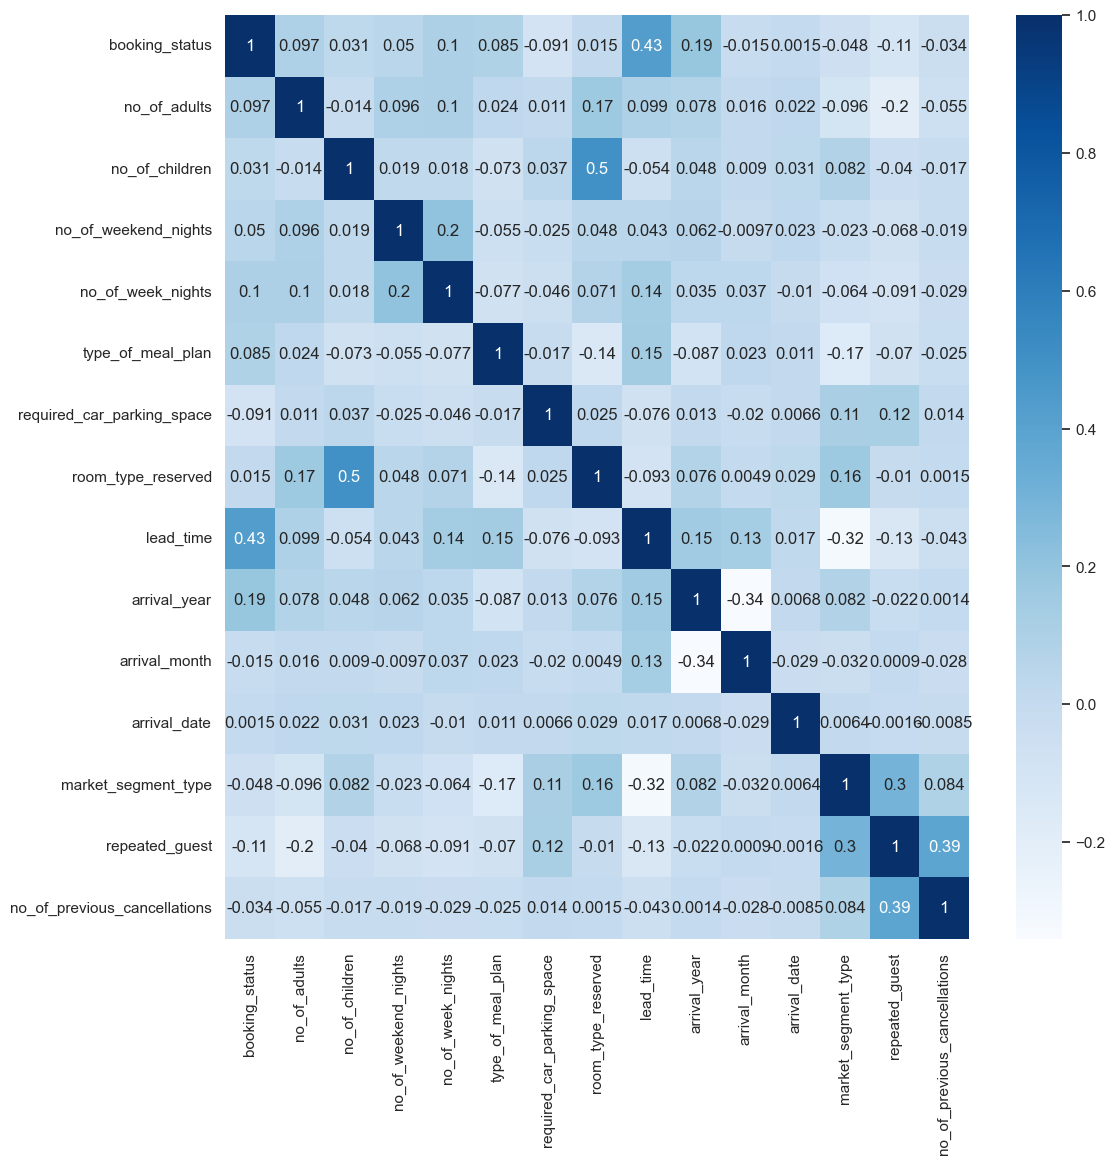

In [106]:
cor = pd.concat((train_df_y, train_df_X), axis=1).iloc[:, :15].corr()
plt.figure(figsize=(12, 12))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);


pipe = make_pipeline(r)
feature_names = list(train_df_X.columns.values)
data = {
    "Importance": pipe.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:15]
imps
#taken from lecture

According to the heat map, the lead time has the best correlation with the booking status, however when looking at the importance table, repeated guests seems to hold the most importance.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [128]:
from sklearn.metrics import precision_score
r = RandomForestClassifier(max_depth=15, max_features='log2', n_estimators=50)


r.fit(transformed_x, train_df_y)
score = r.score(transformed_x_test, test_df_y)
print(score)

y_pred =  r.predict(transformed_x_test)

precision = precision_score(test_df_y, y_pred, average = "macro")
precision

0.9403602278992832


0.9387395969023367

The model reports a very high score on the test data. However, this score is higher than the mean cross-validation score which in turn is a sign of overfitting. To further investigate this, I looked at the precision score specifically which was also rather high. While it is possible that they could be over-fitting, the difference between the test and cross-validaton score was approximtely 0.10 units which I believe isn't too significant and can be attributed to could be attributed to random luck. Given this, I have a high confidence level in the model. It is also possible that we have optimization bias here which in turn would lower the conifdence level however given what I said about the difference between the test and cross validation score, the effect optimzation bias, if it present at all, is rather small.

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

The final test score was 0.9411872817496784 and the metric I throught was the most important in this problem was precision. Throughout the assignment, I used a total of 4 model, out of which RandomForestClassifier came out ahead with the logistic regressor coming in second. Compared to the other 2, RandomForestClassifier and Logisitc regressor were both significantly better. All four of them were much higher than the base line. We optimised the hyperparamter C in Logistic Regressor as well as the hyperparameters for Random Forest Classifier. In the case of random forest classifier, i found that the max_depth=15, max_features='log2', n_estimators=50 gave the best results. One thing that particularly shocked me was the test score for the final model was higher than the cross valdiation score despite there being no data leakage. Aside from that, I belive that there were many unnecessary features in the dataset. Dropping these feature could potentially increase the model's performance. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 